# Case Study Part 2

## Todos

- ~~Write Introduction~~
- ~~Write Data formats~~
- ~~Load data~~ 
- ~~Write function to print validation images~~
- ~~Write function to add found boundaries to images~~
- Write function to create predictions
<br>

**Ideas**
- Data Augmentation: Shifting, rotating and so on to increase amount of training data

## Introduction

For one of their projects an insurance company wants to get an estimate of the assets of their clients. For this they want to scan satellite images for four different objects: ponds, pools, photovoltaic systems and trampolines.

### Available data
To solve the task the following data are available.

**Training data**
<br>
The training data consist of five different groups. In the beginning the data themselves are not labels (as in labeled and already in a dataframe form). They are just .png and .jpg files in different subfolders. All training images are of size 256x256 pixels. The following five groups are available:
- Trampoline images: 140 images that contain a trampoline.
- Pond images: 9 images that contain a pond.
- Pool images: 20 images that contain a pool.
- Solar images: 37 images that contain a photovoltaic system.
- Background images: 3110 images that do not contain any of the above-mentioned items.

This sums up to 3316 labeled training patches. 

<br>

**Unlabeled training data**
<br>
In addition to the training patches, 20 validation images are available. They are of size 8000x8000 each and can be used for the manual validation of an approach.

<br>

**Validation data**
<br>
The validation data set contains 3 images of size 8000x8000. In addition there is a csv file that contains the coordinates of an item and a surrounding bounding box of various items and their respective labels.
Thus, one prediction should have the following shape (1,7) with column 1 as strings and the rest as integer values:
|label|y_target|x_target|y_upper_left|x_upper_left|y_lower_right|x_lower_right
|---|---|---|---|---|---|---|
|trampoline|268|278|140|150|396|406|
|...|

<br>

**Predictions** <br>
A prediction should represent a bounding box around a target entity. One prediction consist of the label and the four coordinates that describe the bounding box. <br>
<span style="color:red">The bounding box must be of size 256 x 256</span>. <br>
A prediction is considered correct if the predicted bounding box overlaps at least 50% with the ground truth bounding box. <br>
This overlap is computed as the area of the intersection of the boxes divided by the union of the areas of the boxes: IoU = intersection_area / union_area:

<img src="https://www.baeldung.com/wp-content/uploads/sites/4/2022/04/fig1.png" alt="Intersection over Union for Object Detection | Baeldung on Computer Science">

Our predictions thus must each be of shape (1,5):
|label|y_upper_left|x_upper_left|y_lower_right|x_lower_right
|---|---|---|---|---|
|trampoline|140|150|396|406|
|...|


## Data retrieval

This section loads the training patches into a numpy array and creates the corresponding label vector.
The result are X_train, X_val, y_train and y_val. 

The images are converted to RGB values, which is why there are 3 channels in the training data.

The training data sets are of dimension (number_of_instances x height x width x 3 channels). 
The label vectors only have one dimension (number_of_instances).

In [1]:
from PIL import Image
import numpy as np
import os

In [2]:
def loadImagesToArray(path:str):
    '''
    Loads all .jpg and .png files from the specified directory.\n
    Each image will be converted into an array of size (height x width x channels).\n
    The return numpy array is of dimensions (numberOfImages x height x width x channels).\n
    '''
    imagesArray = []

    counter = 0
    for file in os.scandir(path):
        filepath = os.fsdecode(file)
        if(filepath.endswith(".jpg") or filepath.endswith(".png")):
                imgArray = np.array(Image.open(filepath))
                imagesArray.append(imgArray)
                counter += 1                  
    return np.array(imagesArray)

def loadTrainingDataAndLabels(path:str, subdirectories: list[str]):
    '''
    Loads the training data as numpy arrays and creates the corresponding labels.\n
    For this to work, the images should be under the folder <path> in separate subdirectories, one for each class.\n
    The labels will be inferred from the names of the subdirectories. \n

    Returns the training data as a numpy array with the dimensions (number_of_images x height x width x channels).\n
    Returns the labels as a numpy array with the dimensions (number_of_images).
    '''

    training_data = []
    labels = []

    for directory in subdirectories:
        images_array = loadImagesToArray(os.path.join(path, directory))
        training_data.extend(images_array)

        labels.extend(np.full(len(images_array), directory))

    training_data_array = np.array(training_data)
    print("Shape of training_data: ", training_data_array.shape)
    labels_array = np.array(labels)
    print("Shape of labels: ", labels_array.shape)
    
    return training_data_array, labels_array

In [3]:
training_data, labels = loadTrainingDataAndLabels("data/training_patches/", ["background", "ponds", "pools", "solar", "trampoline"])

from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(labels)
labels_categorical = le.transform(labels)



Shape of training_data:  (3934, 256, 256, 3)
Shape of labels:  (3934,)


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(training_data, labels_categorical, test_size=0.33, random_state=1, stratify=labels)

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, dtype="int8")
np.unique(y_train, axis=0)

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0]], dtype=int8)

In [5]:
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Conv2D, MaxPool2D
from tensorflow import keras
model = keras.models.Sequential()
model.add(InputLayer(input_shape=(256,256,3)))
model.add(Conv2D(filters=10, kernel_size=(3,3), strides=1, padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(20, activation="relu"))
model.add(Dense(20, activation="relu"))
model.add(Dense(5, activation="softmax"))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 10)      280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 10)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 163840)            0         
                                                                 
 dense (Dense)               (None, 20)                3276820   
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 5)                 105       
                                                        

In [7]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [8]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=20,
                    batch_size=64,
                    validation_split=0.1,
                   )

Epoch 1/20
38/38 [==============================] - 6s 44ms/step - loss: 638.4708 - accuracy: 0.5770 - val_loss: 494.0076 - val_accuracy: 0.7803
Epoch 2/20
38/38 [==============================] - 1s 39ms/step - loss: 164.0669 - accuracy: 0.6858 - val_loss: 36.4162 - val_accuracy: 0.7727
Epoch 3/20
38/38 [==============================] - 1s 38ms/step - loss: 10.7032 - accuracy: 0.7440 - val_loss: 3.1609 - val_accuracy: 0.8068
Epoch 4/20
38/38 [==============================] - 1s 40ms/step - loss: 1.5757 - accuracy: 0.8785 - val_loss: 1.9977 - val_accuracy: 0.8523
Epoch 5/20
38/38 [==============================] - 2s 40ms/step - loss: 0.7139 - accuracy: 0.9211 - val_loss: 1.5122 - val_accuracy: 0.8144
Epoch 6/20
38/38 [==============================] - 2s 42ms/step - loss: 0.4923 - accuracy: 0.9422 - val_loss: 1.4676 - val_accuracy: 0.8371
Epoch 7/20
38/38 [==============================] - 2s 45ms/step - loss: 0.3691 - accuracy: 0.9629 - val_loss: 1.5463 - val_accuracy: 0.8561
Epoch

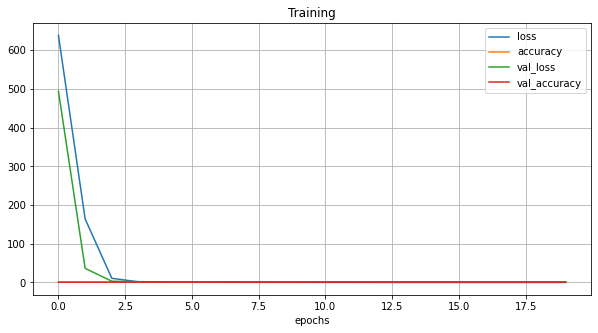

In [9]:
import pandas
%matplotlib inline
import matplotlib.pyplot as plt
def plot_history(history, title):
    df = pandas.DataFrame(history.history)
    ax = df.plot(figsize=(10,5))
    plt.grid(True)
    ax.set_title(title)
    ax.set_xlabel("epochs")
    plt.show()

plot_history(history, "Training")

In [10]:
preds = model.predict(X_val)


41/41 [==============================] - 1s 13ms/step


In [17]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
preds_argmaxed = np.apply_along_axis(np.argmax, 1, preds)
f1_score(y_val,preds_argmaxed, average='weighted'), accuracy_score(y_val, preds_argmaxed) 

(0.8595519523372432, 0.8752886836027713)

In [12]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_val, preds_argmaxed)

array([[1010,    0,    0,    0,   17],
       [   8,    0,    0,    0,    4],
       [   9,    1,    6,    4,    6],
       [  10,    0,    0,   17,   22],
       [  70,    1,    0,   10,  104]], dtype=int64)

In [31]:
X_val_test = np.concatenate((X_val_test, X_val_test))
len(X_val_test)

62352

In [32]:
%%time
model.predict(X_val)

41/41 [==============================] - 1s 18ms/step
CPU times: total: 2.05 s
Wall time: 3.41 s


array([[9.9860829e-01, 1.9732315e-06, 7.0942173e-05, 2.1564708e-10,
        1.3187268e-03],
       [2.9691565e-03, 5.8956272e-07, 1.4427280e-04, 1.7292208e-04,
        9.9671304e-01],
       [9.9992442e-01, 7.6408981e-18, 3.0779989e-15, 4.9080889e-25,
        7.5597112e-05],
       ...,
       [9.9016118e-01, 4.1163349e-07, 6.6306512e-07, 2.1525566e-09,
        9.8377103e-03],
       [9.6809107e-01, 1.6990883e-03, 1.9101940e-02, 2.8670104e-06,
        1.1104958e-02],
       [9.8776281e-01, 3.9758444e-05, 3.4636581e-05, 5.9099371e-08,
        1.2162732e-02]], dtype=float32)

## Data Augmentation

In [20]:
import PIL

def rotateDirectory(directory,folder):

    directory = directory + folder
    
    for file in os.scandir(directory):
        filepath = os.fsdecode(file)      	
        pathname, extension = os.path.splitext(filepath)
        
        if(filepath.endswith(".jpg") or filepath.endswith(".png")):
                img = Image.open(filepath)
                img_180 = img.rotate(180, expand = 0)
                img_90 = img.rotate(90, expand = 0)
                img_270 = img.rotate(270, expand = 0)
                pathname, extension = os.path.splitext(filepath)
                
                filename = str(pathname.split('/')[1])
                print(str(filename))

                img_180.save("training_patches2" +"/" + filename + "_180" +".png")
                img_90.save("training_patches2" +"/" +filename + "_90" +".png")
                img_270.save("training_patches2" +"/" +filename + "_270" +".png")


rotateDirectory("training_patches/", "solar")
rotateDirectory("training_patches/", "ponds")
rotateDirectory("training_patches/", "trampoline")
rotateDirectory("training_patches/", "pools")

solar\2KW62C
solar\2PUTC6
solar\3GW0K4
solar\3HINQE
solar\4QPFM4
solar\55W5VY
solar\5I9LFY
solar\5PV7W2
solar\6LH73S
solar\8SWK8X
solar\9OZEOL
solar\AE7DYU
solar\BGAYTE
solar\C2EO4W
solar\CHS1VJ
solar\DL33FV
solar\ETDQL6
solar\F0KOY0
solar\GS6RL1
solar\H1OWXF
solar\J243RT
solar\JTGJZ5
solar\KT63D7
solar\KYFJOS
solar\NXFPK7
solar\OFYL3P
solar\OTQF8W
solar\RPZNXZ
solar\S10UHC
solar\TOMNU9
solar\UO3T1I
solar\UO6VM6
solar\VMGEOX
solar\XMYG4S
solar\YNA5KS
solar\Z1ED0G
solar\ZKE70N
ponds\2DJK4I
ponds\81H8S5
ponds\AG0B66
ponds\C6KH5X
ponds\FYVAQ8
ponds\ICCE3B
ponds\JSHXCK
ponds\NHQAGS
ponds\W4XKKI
trampoline\02LHCT
trampoline\06S4JA
trampoline\0BO2WG
trampoline\0KWC9E
trampoline\0PWZI1
trampoline\0UT826
trampoline\11X9IO
trampoline\136M2H
trampoline\17A812
trampoline\1BUEV5
trampoline\1CED4V
trampoline\1E9VX9
trampoline\1GGBLF
trampoline\1H2JXB
trampoline\262C7K
trampoline\2URTZG
trampoline\3CBKH8
trampoline\3JLVHW
trampoline\3VLWQS
trampoline\4EIGES
trampoline\5EACZA
trampoline\5LQPQP
trampo

## Model Selection

## Model Training

## Model Validation

This section contains code that is needed to create predictions, save them and to print the training / validation images - either with or without the predicted bounding boxes.

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2 as cv
import pandas as pd
from pathlib import Path

In [6]:
def savePredictionToCsv(predictionDataframe: pd.DataFrame, filepath:str):
    '''
    Saves a dataframe containing the prediction for a single image to a CSV file.

    @predictionDataFrame - The dataframe that contains the predictions and should be saved.\n
    @path - The path under which the CSV file should be saved.
    @filename - The name under which the CSV file should be saved.
    '''
    predictionDataframe.to_csv(filepath, sep=",", index=False)

def makePredictions(path:str):
    '''
    Traverses a folder that contains images for which predictions should be made.\n
    Creates a separate prediction CSV file for each image.

    @path - The path containing the images for which predictions should be created.
    '''
    fake_predictions = {"label":["something"], "y_upper_left": [100], "x_upper_left":[100], "y_lower_right":[356], "x_lower_right":[356]}
    dataframe = pd.DataFrame(data=fake_predictions)
    counter = 0
    for file in os.scandir(path):
        filepath = os.fsdecode(file)

        if(not (filepath.endswith(".jpg") or filepath.endswith(".png")) or ("annotated" in filepath)):
            continue
        print("Making prediction for file: ", file.name) 
        savePredictionToCsv(dataframe, os.path.splitext(filepath)[0]+".csv")
        counter += 1
    print("Created ",counter, " predictions.")

def saveOrPrintImages(path:str, print_to_output:bool=False, valBoundingBoxes: bool = False, thickness: int = 2, saveImagesPath:str=""):
    '''
    Loads and saves all .jpg and .png files from the specified directory.\n

    @print - If set to True, will print the (annotated) images to the output (takes some time). Default value is False.

    @valBoundingBoxes If set to true, the method will load the bounding box data from the csv files. The default for this is False.\n
  
    @thickness parameter determines how thick the bounding boxes are drawn on the image (width of the line in pixels). The default value is 2.\n

    @saveImagesPath If specified will save the drawn images at the specified path.

    '''
    for file in os.scandir(path):
        filepath = os.fsdecode(file)
       

        if(not (filepath.endswith(".jpg") or filepath.endswith(".png"))  or ("annotated" in filepath)):
            continue

        print("Saving / printing file: ",os.path.splitext(file.name)[0],"_annotated.jpg")
        image = cv.imread(filepath) 
        
        if(valBoundingBoxes):
            image = addBoundingBoxesFromCsv(image, filepath, thickness)

        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        # Convert to PIL format
        image = Image.fromarray(image)
        if(saveImagesPath):
            image.save(saveImagesPath+"/"+ os.path.splitext(file.name)[0]+"_annotated.jpg", "JPEG")

        if(print_to_output):
            image.show()
        

def addBoundingBoxesFromCsv(image: cv.Mat, filepath:str, thickness: int) -> cv.Mat:
    '''
    Uses a csv file containing the predictions for a single image to draw bounding boxes into an image.\n

    Performs the changes in place and returns the modified image.
    The image parameter specifies the image to be modified.
    The filepath must contain the path of the csv file that contains the bounding box predictions for this image.
    '''
    csvPath = os.path.splitext(filepath)[0]+".csv"
    boundingBoxesDataframe = pd.read_csv(csvPath, delimiter=",", header=0 )

    for index,boundingBox in boundingBoxesDataframe.iterrows():
        label = boundingBox[0]
        start_point = (boundingBox["x_upper_left"],boundingBox["y_upper_left"])
        end_point = (boundingBox["x_lower_right"], boundingBox["y_lower_right"])

        color:str
        
        if(label== "background"):
            color=(255,255,255) # (BGR) White
        elif(label == "pool"):
            color=(255,255,0) # (BGR) Cyan
        elif(label == "pond"):
            color=(0,128,0) # (BGR) Green
        elif(label == "solar"):
            color=(255,0,0) # (BGR) Blue
        elif(label == "trampoline"):
            color=(0,255,255) # (BGR) Yellow
        else:
            color=(180,105,255) # (BGR) Pink if no label present
        image = cv.rectangle(image, start_point, end_point, color, thickness=thickness)
    
    return image

## Model Validation (Unlabeled Training Data)

This section prints the unlabeled training images along with bounding boxes that are retrieved from the corresponding CSV files.

In [7]:
makePredictions(path="./data/unlabeled_training_data/")
saveOrPrintImages(path="./data/unlabeled_training_data/", print_to_output=False, valBoundingBoxes=True,saveImagesPath="./data/unlabeled_training_data/", thickness=5)

Making prediction for file:  0FRGJD.png
Making prediction for file:  3938J9.png
Making prediction for file:  6ATLJM.png
Making prediction for file:  6FPS9I.png
Making prediction for file:  73COYK.png
Making prediction for file:  9Q69FH.png
Making prediction for file:  B7DBOX.png
Making prediction for file:  BFVATM.png
Making prediction for file:  CM380U.png
Making prediction for file:  DHX1Z3.png
Making prediction for file:  FML5SH.png
Making prediction for file:  G8MS91.png
Making prediction for file:  JBN1LY.png
Making prediction for file:  NNP6V0.png
Making prediction for file:  P5L1VO.png
Making prediction for file:  RXRIIW.png
Making prediction for file:  S9CT2G.png
Making prediction for file:  W0E9JC.png
Making prediction for file:  W4XC08.png
Making prediction for file:  XRZXKK.png
Created  20  predictions.
Saving / printing file:  0FRGJD _annotated.jpg
Saving / printing file:  3938J9 _annotated.jpg
Saving / printing file:  6ATLJM _annotated.jpg
Saving / printing file:  6FPS9I _

## Printing the validation images

This section prints the public test data images along with their respective predictions / bounding boxes.

In [9]:
# Print images from the validation data and use the corresponding csv files to add bounding boxes of classified entities
saveOrPrintImages("data/validation_data/", print_to_output=False, valBoundingBoxes=True, thickness=5, saveImagesPath="./data/validation_data/")

Saving / printing file:  DQIMQN _annotated.jpg
Saving / printing file:  L7CT2I _annotated.jpg
Saving / printing file:  UDPYYD _annotated.jpg
